# Ground observing schedules

In this notebook we learn about creating ground observing schedules.

In [1]:
# Are you using a special reservation for a workshop?
# If so, set it here:
nersc_reservation = "toast3"

# Load common tools for all lessons
import sys
sys.path.insert(0, "..")
from lesson_tools import (
    check_nersc,
    fake_focalplane
)
nersc_host, nersc_repo, nersc_resv = check_nersc(reservation=nersc_reservation)

# Capture C++ output in the jupyter cells
%reload_ext wurlitzer

Running on NERSC machine 'cori'
  with access to repos: mp107
Using default repo mp107


TOAST `pipelines` include a tool called `toast_ground_schedule.py`, also known as the *opportunistic scheduler*.  It builds observing schedules heuristically by building a list of available targets and scheduling and always choosing the highest priority target. `toast_ground_schedule.py` can be used to create site-specific observing schedules subject to a number of constraints. At the minimum, the tool needs the location of the observatory, observing window and at least one target. Here is a minimal example:

In [4]:
! toast_ground_schedule.py \
    --site-lat "-22.958064" \
    --site-lon "-67.786222" \
    --site-alt 5200 \
    --site-name Atacama \
    --telescope LAT \
    --start "2020-01-01 00:00:00" \
    --stop "2020-01-01 12:00:00" \
    --patch-coord C \
    --patch small_patch,1,40,-40,44,-44 \
    --out schedule.txt

#pathc small patch sets priority of the patch then defining the corners RA left, DEC top, RA right, DEC bottom

TOAST INFO: Adding patch "small_patch"
TOAST INFO: Rectangular format
TOAST INFO: Global timer: toast_ground_schedule:  0.15 seconds (1 calls)


Let's look at the contents of the schedule file.

In [5]:
! cat schedule.txt

#Site            Telescope        Latitude [deg] Longitude [deg]   Elevation [m]
 Atacama         LAT                     -22.958         -67.786          5200.0
#Start time UTC       Stop time UTC        Start MJD      Stop MJD       Patch name                          Az min   Az max   El       R/S   Sun el1  Sun az1  Sun el2  Sun az2  Moon el1 Moon az1 Moon el2 Moon az2 Phase Pass  Sub
 2020-01-01 00:50:00  2020-01-01 01:04:45    58849.034722   58849.044965 small_patch                           189.14   196.61    68.69 S       -18.68   233.69   -21.38   231.50    34.93   274.35    31.60   272.86  0.30     0   0
 2020-01-01 01:04:55  2020-01-01 01:19:40    58849.045081   58849.055324 small_patch                           189.19   205.13    68.69 S       -21.41   231.47   -24.02   229.13    31.56   272.84    28.22   271.42  0.30     0   1
 2020-01-01 01:19:50  2020-01-01 01:34:35    58849.055440   58849.065683 small_patch                           196.64   213.71    68.69 S       -24.

The rectangular patch definition takes the form `--patch <name>,<priority>,<RA left>,<DEC top>,<RA right>,<DEC bottom>`. No spaces are allowed in the definition.  Other patch definition formats will be discussed below.

The start and stop times are given in UTC.

The resulting schedule is a plain ASCII file. The header defines the telescope and each line after that defines a constant elevation scan (CES) with a fixed azimuth range. When a full pass of the target takes longer than allowed observation time, `--ces-max-time`, the CES is broken up into sub passes that use the same observing elevation but adjust the azimuth range.  The above schedule includes 10 passes of the target "small_patch" that fit in the given 12-hour observing window. Some passes are split into as many as 4 sub passes, each no longer than 20 minutes (default).

Let's add another patch, this time using the circular patch definition format, set the observing elevation limits and enable Sun avoidance. We'll also increase `ces-max-time` so we get fewer entries in the schedule.  The circular patch format is

`--patch <name>,<priority>,<RA>,<DEC>,<radius>`

scan stopped as the patch dropped below the min az and could no longer be observed, and there were no other targets to observe

In [6]:
! toast_ground_schedule.py \
    --site-lat "-22.958064" \
    --site-lon "-67.786222" \
    --site-alt 5200 \
    --site-name Atacama \
    --telescope LAT \
    --start "2020-01-01 00:00:00" \
    --stop "2020-01-04 00:00:00" \
    --patch-coord C \
    --patch small_patch,1,80,-13,10 \
    --patch large_patch,1,80,-33,20 \
    --el-min 30 \
    --el-max 60 \
    --ces-max-time 86400 \
    --sun-avoidance-angle 20 \
    --out schedule.txt \
    --debug

! cat schedule.txt

TOAST INFO: Adding patch "small_patch"
TOAST INFO: Center-and-width format
TOAST INFO: Adding patch "large_patch"
TOAST INFO: Center-and-width format
TOAST INFO: small_patch corners:
 lon = [80.0, 82.52889698392441, 84.40387023305097, 85.13152053896695, 84.49355559956005, 82.61888616230056, 80.0, 77.38111383769943, 75.50644440043996, 74.86847946103305, 75.596129766949, 77.47110301607557, 80.0]
 lat= [-8.000000000000002, -8.669872981077807, -10.5, -13.0, -15.5, -17.33012701892219, -18.0, -17.330127018922195, -15.500000000000002, -13.000000000000002, -10.500000000000004, -8.66987298107781, -8.000000000000002]
TOAST INFO: large_patch corners:
 lon = [80.0, 85.48776585034872, 89.80834435462137, 91.92363292835948, 90.99002012118036, 86.69254923971052, 80.0, 73.3074507602895, 69.00997987881962, 68.07636707164052, 70.19165564537862, 74.51223414965126, 80.0]
 lat= [-23.0, -24.339745962155618, -28.0, -33.0, -38.0, -41.66025403784439, -43.0, -41.66025403784439, -38.00000000000001, -33.0, -28.000

Note that we added the `--debug` option to the command line. This produces a helpful diagnostic plot, `patches.png`, that shows the locations of your patches, the Sun, the Moon and their avoidance areas.  The plot is shown below. The motion of the Moon (multicolored smear) is already apparent in this 3-day schedule.  The Sun (on the right) is effectively stationary.  `--debug` can be expensive, especially if you have lots of patches or request a long observing schedule.

The coordinates have been defined as the center of the patch and the radius of it. TOAST then breaks this into a polygon with 12 discrete corners. The max and min Az have been set for the telescope, and sun avoidance has been included. 
Whatis the max scan time? why?

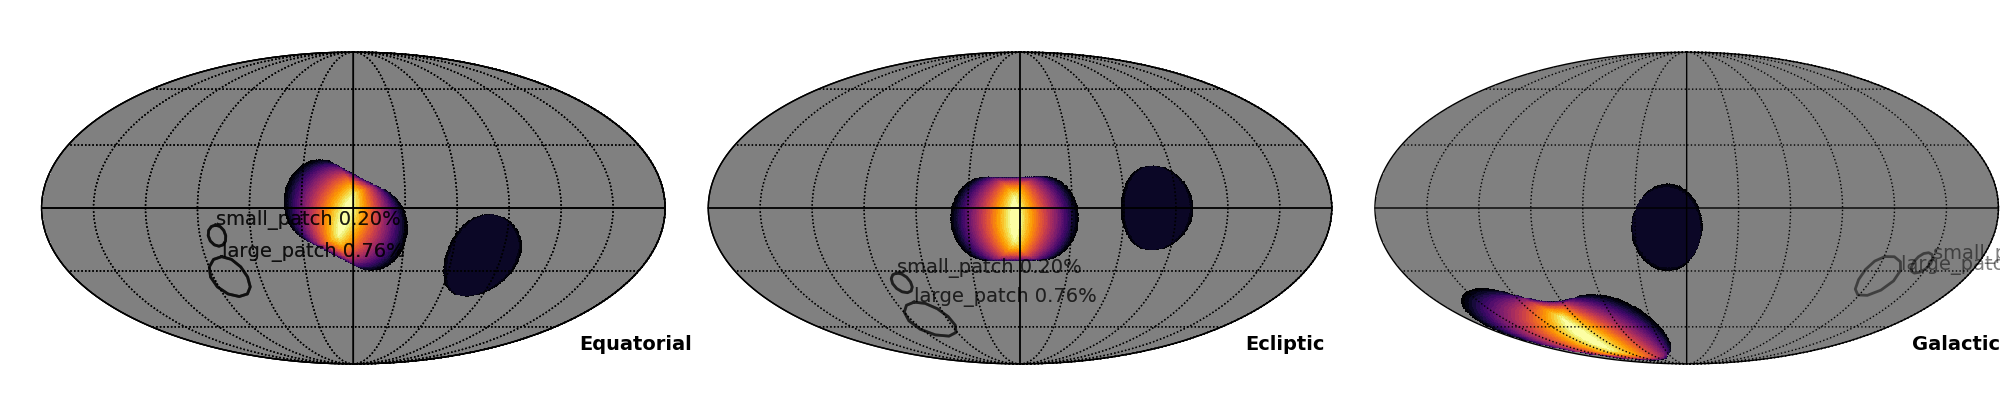

In [7]:
from IPython.display import Image
Image("patches.png")

We deliberately chose the locations of the patches so that they compete over the observing time.  This allows us to point out some advanced features of the scheduler.  If you examine the very end of the observing schedule, you can note that both `small_patch` and `large_patch` were observed 7 times.  Given that `large_patch` is twice as wide and only takes twice as long to observe, equal number of observations actually implies that `large_patch` will end up with *half* as many hits per sky pixel.

The scheduler offers two ways to remedy this issue. First, one can simply increase the priority of the large patch to dedicate more observing time to it.  **All things being equal, the number of visits to a given patch is inversely proportional to the `priority` in the patch definition**:

interpret as may want to make the the priority proportional to the quality and the size of the patch? EG if small and large patch are equal quality observing locations giving them equal priority will result in a shallower large patch because it has a larger area and will need more time to integrate it to the same depth. 

In [8]:
! toast_ground_schedule.py \
    --site-lat "-22.958064" \
    --site-lon "-67.786222" \
    --site-alt 5200 \
    --site-name Atacama \
    --telescope LAT \
    --start "2020-01-01 00:00:00" \
    --stop "2020-01-04 00:00:00" \
    --patch-coord C \
    --patch small_patch,1,80,-13,10 \
    --patch large_patch,0.5,80,-33,20 \
    --el-min 30 \
    --el-max 60 \
    --ces-max-time 86400 \
    --sun-avoidance-angle 20 \
    --out schedule.txt

! cat schedule.txt

TOAST INFO: Adding patch "small_patch"
TOAST INFO: Center-and-width format
TOAST INFO: Adding patch "large_patch"
TOAST INFO: Center-and-width format
TOAST INFO: Global timer: toast_ground_schedule:  0.70 seconds (1 calls)
#Site            Telescope        Latitude [deg] Longitude [deg]   Elevation [m]
 Atacama         LAT                     -22.958         -67.786          5200.0
#Start time UTC       Stop time UTC        Start MJD      Stop MJD       Patch name                          Az min   Az max   El       R/S   Sun el1  Sun az1  Sun el2  Sun az2  Moon el1 Moon az1 Moon el2 Moon az2 Phase Pass  Sub
 2020-01-01 00:00:00  2020-01-01 01:37:00    58849.000000   58849.067361 large_patch                            97.31   134.88    56.91 R        -9.03   240.13   -26.97   226.16    46.19   280.16    24.30   269.81  0.30     0   0
 2020-01-01 04:28:40  2020-01-01 06:07:40    58849.186574   58849.255324 large_patch                           221.76   263.40    59.94 S       -43.98   18

Now the large patch is observed 9 times and the small patch is observed 4 times.  Typically though, we don't use the priority field to normalize the depths.  Instead, the user can balance the integration depths with two command line arguments: `--equalize-area` and `--equalize time`.

With `--equalize-area` the scheduler will automatically modulate the user-given priorities with the area of each patch.

With `--equalize-time` the scheduler will balance the actual time spent in each patch rather than the number of visits.  There is a difference, because the observing time per pass can vary greatly depending on the patch shape and orientation

In [9]:
! toast_ground_schedule.py \
    --site-lat "-22.958064" \
    --site-lon "-67.786222" \
    --site-alt 5200 \
    --site-name Atacama \
    --telescope LAT \
    --start "2020-01-01 00:00:00" \
    --stop "2020-01-04 00:00:00" \
    --patch-coord C \
    --patch small_patch,1,80,-13,10 \
    --patch large_patch,1,80,-33,20 \
    --el-min 30 \
    --el-max 60 \
    --ces-max-time 86400 \
    --sun-avoidance-angle 20 \
    --equalize-area \
    --equalize-time \
    --out schedule.txt

! cat schedule.txt

TOAST INFO: Adding patch "small_patch"
TOAST INFO: Center-and-width format
TOAST INFO: Adding patch "large_patch"
TOAST INFO: Center-and-width format
TOAST INFO: Global timer: toast_ground_schedule:  6.79 seconds (1 calls)
#Site            Telescope        Latitude [deg] Longitude [deg]   Elevation [m]
 Atacama         LAT                     -22.958         -67.786          5200.0
#Start time UTC       Stop time UTC        Start MJD      Stop MJD       Patch name                          Az min   Az max   El       R/S   Sun el1  Sun az1  Sun el2  Sun az2  Moon el1 Moon az1 Moon el2 Moon az2 Phase Pass  Sub
 2020-01-01 00:00:00  2020-01-01 01:37:00    58849.000000   58849.067361 large_patch                            97.31   134.88    56.91 R        -9.03   240.13   -26.97   226.16    46.19   280.16    24.30   269.81  0.30     0   0
 2020-01-01 04:28:40  2020-01-01 06:07:40    58849.186574   58849.255324 large_patch                           221.76   263.40    59.94 S       -43.98   18

As with the by-hand-modulated priorities, `large_patch` ends up with twice as many visits.

## Binning the schedule

We take an observing schedule from `toast_ground_sim.py` and translate it into a depth map.

First, we need a focalplane. If one does not already exist, TOAST `pipelines` includes a tool for generating mock hexagonal focalplanes:

In [10]:
! toast_fake_focalplane.py --help

usage: toast_fake_focalplane.py [-h] [--minpix MINPIX] [--out OUT]
                                [--fwhm FWHM] [--fwhm_sigma FWHM_SIGMA]
                                [--fov FOV] [--psd_fknee PSD_FKNEE]
                                [--psd_NET PSD_NET] [--psd_alpha PSD_ALPHA]
                                [--psd_fmin PSD_FMIN]
                                [--bandcenter_ghz BANDCENTER_GHZ]
                                [--bandcenter_sigma BANDCENTER_SIGMA]
                                [--bandwidth_ghz BANDWIDTH_GHZ]
                                [--bandwidth_sigma BANDWIDTH_SIGMA]
                                [--random_seed RANDOM_SEED]

Simulate fake hexagonal focalplane.

optional arguments:
  -h, --help            show this help message and exit
  --minpix MINPIX       minimum number of pixels to use
  --out OUT             Root name of output pickle file
  --fwhm FWHM           beam FWHM in arcmin
  --fwhm_sigma FWHM_SIGMA
                        Relative beam F

Now we create a focalplane with 10-degree FOV and a mininimum of 20 pixels:

In [11]:
! toast_fake_focalplane.py \
    --minpix 20 \
    --out focalplane \
    --fwhm 30 \
    --fov 10 \
    --psd_fknee 5e-2 \
    --psd_NET 1e-3 \
    --psd_alpha 1 \
    --psd_fmin 1e-5

TOAST INFO: using 37 pixels (74 detectors)


The actual focalplane ends up having 37 pixels, instead of the minimum of 20.  This is because regular packing of the hexagon is quantized.  Notice that the final name of the focalplane is `focalplane_37.pkl`.  We'll need the name to run the simulation script.

We will use the versatile ground simulation pipeline, `toast_ground_sim.py`, to bin the map.  It will be covered in detail in lesson 7 so here we simply write out a parameter file:

In [12]:
%%writefile bin_schedule.par
--sample-rate
1
--scan-rate
0.3
--scan-accel
10.0
--nside
64
--focalplane
focalplane_37.pkl
--schedule
schedule.txt
--out
out
--simulate-noise
--freq
100
--no-destripe
--no-binmap
--hits
--wcov

Writing bin_schedule.par


Then run the pipeline. Because the pipeline uses `libMadam`, an MPI code, we must submit the job to a compute node.

In [13]:
import subprocess as sp

command = "toast_ground_sim.py @bin_schedule.par"
runstr = None

if nersc_host is not None:
    runstr = "srun -N 1 -C haswell -n 32 -c 2 --cpu_bind=cores -t 00:05:00"
    if nersc_resv is not None:
        runstr = "{} --reservation {}".format(runstr, nersc_resv)
else:
    # Just use mpirun
    runstr = "mpirun -np 4"

runcom = "{} {}".format(runstr, command)
print(runcom, flush=True)
sp.check_call(runcom, stderr=sp.STDOUT, shell=True)


Let's examine the resulting hits and depth map.  The file naming convention may seem a little awkward but follows from the fact that a single run of `toast_ground_sim.py` may map multiple telescopes, frequencies and time splits.

NSIDE = 64
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


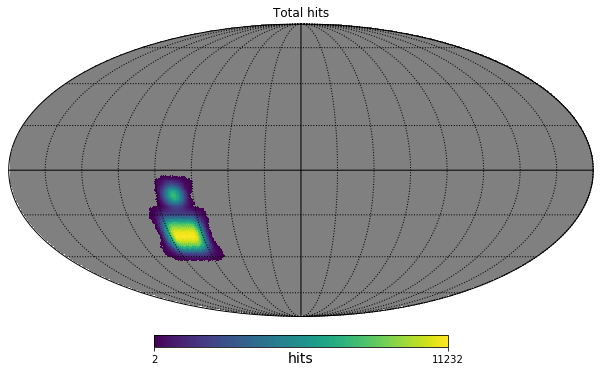

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
import healpy

hits = healpy.read_map("out/00000000/100/toast_100_telescope_all_time_all_hmap.fits")
hits[hits == 0] = healpy.UNSEEN
healpy.mollview(hits, unit="hits", title="Total hits")
healpy.graticule(22.5, verbose=False)

NSIDE = 64
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


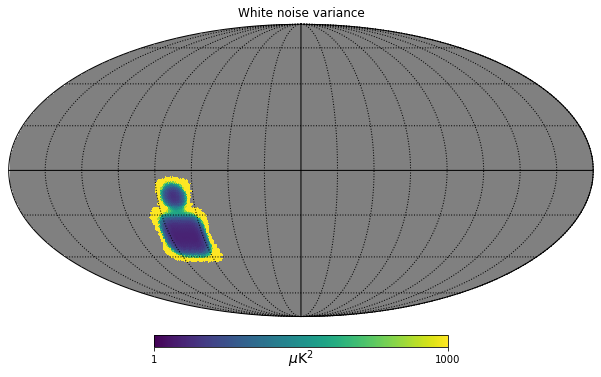

In [17]:
wcov = healpy.read_map("out/00000000/100/toast_100_telescope_all_time_all_wcov.fits")
wcov *= 1e12  # from K^2 to uK^2
wcov[wcov == 0] = healpy.UNSEEN
healpy.mollview(wcov, unit="$\mu$K$^2$", title="White noise variance", min=1e0, max=1e3)
healpy.graticule(22.5, verbose=False)

## Advanced topics in ground scheduling

### Cooler cycle format
it is possible to instruct the scheduler to add regular breaks in the schedule to cycle the cooler or to perform other maintenance activities. The cooler cycle is a pseudo patch that the scheduler considers like other targets when deciding what to observe next.  The full syntax is:

`--patch <name>,COOLER,<weight>,<power>,<hold_time_min>,<hold_time_max>,<cycle_time>,<az>,<el>`

All of the time arguments are given in hours.  The priority of the patch depends on the time since the last cycle occurred. It is `infinity` until `hold_time_min` has elapsed and then begins to decrease according to a power law set by `power`.  Priority at `hold_time_max` is zero.

### Planet scans

The scheduler can target planets just like stationary patches.  The SSO (solar system object) format is

`--patch <name>,SSO,<priority>,<radius [deg]>`

All orbiting bodies recognized by `pyEphem` are supported.

### Oscillating patches

The scheduler designs the scans so that the azimuth range is kept fixed and the boresight sweeps the entire patch.  This usually implies a certain amount of spillover integration time outside the patch.  This can produce an excess of hits at the boundary of two patches.  The scheduler offers a way to smear the spillover by systematically shifting the position of the patches in RA and DEC.  The arguments to accomplish this are

`--ra-period <period [visits]>`

`--ra-amplitude <amplitude [deg]>`

`--dec-period <period [visits]>`

`--dec-amplitude <amplitude [deg]>`

Patches will systematically shift after each visit, returning to their fiducial positions after each period.

### Horizontal (high cadence) patch definition

Horizontal patch definition specifies the observing elevation and the azimuth range. The scheduler parks the telescope at the given elevation and scans until the constraints (Sun, Moon, cooler hold time) prevent continuing.  If possible, scanning is continued by switching between rising and setting scan.

`--patch <name>,HORIZONTAL,<priority>,<az min [deg]>,<az max [deg]>,<el [deg]>,<scan time [min]>`

### Polygon patch definition

Patches do not need to be rectangular or circular.  An arbitrary polygon shape can be specified by giving the corner coordinates.

`--patch <name>,<priority>,<RA_0 [deg]>,<DEC_0 [deg]>,...,,<RA_N-1 [deg]>,<DEC_N-1 [deg]>`

### Elevation penalty

Lower observing elevations are subject to higher levels of photon noise from the atmosphere.  It is possible to instruct the scheduler to modulate the relative priorities of the available patches based on their elevation. 

`--elevation-penalty-limit <elevation [deg]>`

`--elevation-penalty-power <power>`

If the available patch is below `elevation-penalty-limit`, the priority is modulated by $\left(\frac{limit}{elevation}\right)^{power}$. This way low elevation scans are reserved for targets that cannot be observed at higher elevation or when no targets are available higher.

### Block-out

January and February weather in the Atacama is known to be problematic for observing.  It is possible to instruct the scheduler to skip certain periods of the calendar year with

`--block-out <start month>/<start day>-<end month>/<end day>`

or with

`--block-out <start year>/<start month>/<start day>-<end year>/<end month>/<end day>`

All fields are integers.  The dates are in UTC.

### Gaps

The are two short gap lengths in the scheduler

`--gap-small <gap [s]>`

`--gap <gap [s]>`

The `gap-small` is applied when a single CES is broken up into sub scans.  The regular `gap` is applied between separate observations.

### Pole scheduling

Observing from the Poles is unlike anywhere else on Earth.  Patches will not drift across a constant elevation line.  Instead, the telescope must be stepped in elevation.  The Pole scheduling mode is enabled with 

`--pole-mode`

And the step time and size are controlled with

`--pole-el-step <step [deg]>`

`--pole-ces-time <time [s]>`

In [14]:
#    --site-lat "-89:59.464" \
#    --site-lon "-44:39" \

! toast_ground_schedule.py \
    --site-lat "-89.991" \
    --site-lon "-44.65" \
    --site-alt 2843 \
    --site-name South_Pole \
    --telescope LAT \
    --start "2020-01-01 00:00:00" \
    --stop "2020-01-01 12:00:00" \
    --patch-coord C \
    --patch small_patch,1,40,-40,44,-44 \
    --pole-mode \
    --pole-el-step 0.25 \
    --pole-ces-time 600 \
    --out pole_schedule.txt

TOAST INFO: Adding patch "small_patch"
TOAST INFO: Rectangular format
TOAST INFO: Global timer: toast_ground_schedule:  0.40 seconds (1 calls)


The resulting schedule has each pass of the target split into (0.25$^\circ$, 10min) steps.  It takes 16 steps (2:40h) to cover the 4$^\circ\times$4$^\circ$ degree field.

In [15]:
! cat pole_schedule.txt

#Site            Telescope        Latitude [deg] Longitude [deg]   Elevation [m]
 South_Pole      LAT                     -89.991         -44.650          2843.0
#Start time UTC       Stop time UTC        Start MJD      Stop MJD       Patch name                          Az min   Az max   El       R/S   Sun el1  Sun az1  Sun el2  Sun az2  Moon el1 Moon az1 Moon el2 Moon az2 Phase Pass  Sub
 2020-01-01 00:00:00  2020-01-01 00:10:00    58849.000000   58849.006944 small_patch                           342.47   348.72    39.94 S        23.08   225.42    23.08   222.92     9.16   293.70     9.13   291.27  0.30     0   0
 2020-01-01 00:11:40  2020-01-01 00:21:40    58849.008102   58849.015046 small_patch                           339.54   345.80    40.19 S        23.08   222.50    23.08   220.00     9.12   290.87     9.09   288.44  0.30     0   1
 2020-01-01 00:23:20  2020-01-01 00:33:20    58849.016204   58849.023148 small_patch                           336.62   342.87    40.44 S        23.

Let's bin this schedule as well.  We also demonstrate how parameters in the parameter file may be overridden

In [18]:
command = "toast_ground_sim.py @bin_schedule.par --schedule pole_schedule.txt --out out_pole"
runstr = None

if nersc_host is not None:
    runstr = "srun -N 1 -C haswell -n 32 -c 2 --cpu_bind=cores -t 00:05:00"
    if nersc_resv is not None:
        runstr = "{} --reservation {}".format(runstr, nersc_resv)
else:
    # Just use mpirun
    runstr = "mpirun -np 4"

runcom = "{} {}".format(runstr, command)
print(runcom, flush=True)
sp.check_call(runcom, stderr=sp.STDOUT, shell=True)


NSIDE = 64
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


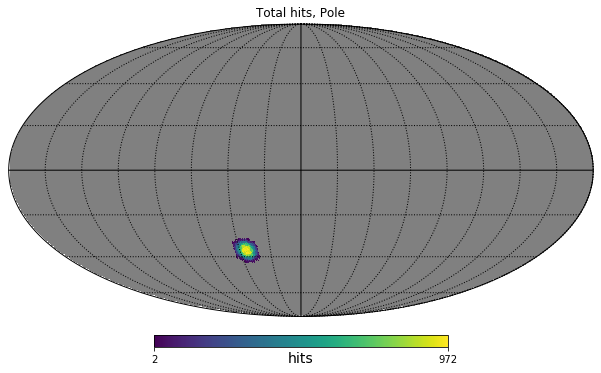

In [19]:
hits = healpy.read_map("out_pole/00000000/100/toast_100_telescope_all_time_all_hmap.fits")
hits[hits == 0] = healpy.UNSEEN
healpy.mollview(hits, unit="hits", title="Total hits, Pole")
healpy.graticule(22.5, verbose=False)